# How to rediscover the Z boson yourself!
This notebook uses ATLAS Open Data http://opendata.atlas.cern to show you the steps to rediscover the Z boson yourself!

The idea is that you add extra cuts to increase the ratio of signal ($Z \rightarrow e^{+}e^{-}$ and $Z \rightarrow \mu^{+}\mu^{-}$) to background ($Z \rightarrow \tau^{+}\tau^{-}$, $W$, single top, $t\bar{t}$, dibosons, low-mass Drell-Yan)

The datasets used in this notebook have already been filtered to include exactly 2 leptons per event, so that processing is quicker.

<CENTER><img src="Z_feynman.pdf" style="width:40%"></CENTER>

## First time setup
This first cell only needs to be run the first time you open this notebook on your computer. 

If you close jupyter and re-open on the same computer, you won't need to run this first cell again.

If you re-open on binder, you will need to run this cell again.

If you run into a problem of "uproot not being available", Kernel -> Restart & Run All

In [11]:
import sys
!{sys.executable} -m pip install --upgrade --user pip
!{sys.executable} -m pip install -U numpy pandas uproot matplotlib --user

Requirement already up-to-date: pip in /Users/meirinevans/.local/lib/python3.7/site-packages (19.3.1)
Requirement already up-to-date: numpy in /Users/meirinevans/.local/lib/python3.7/site-packages (1.17.4)
Requirement already up-to-date: pandas in /Users/meirinevans/.local/lib/python3.7/site-packages (0.25.3)
Requirement already up-to-date: uproot in /Users/meirinevans/.local/lib/python3.7/site-packages (3.10.12)


Requirement already up-to-date: matplotlib in /Users/meirinevans/.local/lib/python3.7/site-packages (3.1.2)


## To setup everytime
Cell -> Run All Below

to be done every time you re-open this notebook

In [40]:
import uproot
import pandas as pd
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # for "Total SM & uncertainty" merged legend handle
from matplotlib.lines import Line2D # for dashed line in legend
from matplotlib.ticker import AutoMinorLocator,LogLocator,LogFormatterSciNotation # for minor ticks
import scipy.stats

import infofile
import labelfile

In [75]:
lumi = 1000

fraction = 0.001 # reduce this is you want the code to run quicker
                                                                                                                                  
tuple_path = "Input/" # local
#tuple_path = "http://opendata.atlas.cern/release/samples/" # web address

stack_order = ['W','single top',r'$t\bar{t}$','Diboson','Drell Yan','Z'] # put smallest contribution first, then increase

In [76]:
samples = {

    'data': {
        'list' : ['DataEgamma','DataMuons']
    },

    'W' : {
        'list' : ['WenuNoJetsBVeto','WenuJetsBVeto','WenuWithB','WmunuNoJetsBVeto','WmunuJetsBVeto','WmunuWithB','WtaunuNoJetsBVeto','WtaunuJetsBVeto','WtaunuWithB'],
        'color' : "#e55934"
    },

    'Z' : {
        'list' : ['Zee','Zmumu','Ztautau'],
        'color' : "#086788"
    },
   
    r'$t\bar{t}$' : {
        'list' : ['ttbar_lep','ttbar_had'],
        'color' : "#9bc53d"
    },

    'single top' : {
        'list' : ['stop_schan','stop_tchan_top','stop_tchan_antitop','stop_wtchan'],
        'color' : "#fde74c"
    },
    
    'Drell Yan' : {
        'list' : ['DYeeM08to15', 'DYeeM15to40', 'DYmumuM08to15', 'DYmumuM15to40', 'DYtautauM08to15', 'DYtautauM15to40'],
        'color' : "#5bc0eb"
    },

    'Diboson' : {
        'list' : ['WW','WZ','ZZ'],
        'color' : "#fa7921"
    }

}

In [77]:
def get_data_from_files():

    data = {}
    
    for s in samples:
        print(s+':')
        frames = []
        for val in samples[s]['list']:
            prefix = "MC/exactly2lep.mc_"
            if s == 'data':
                prefix = "Data/exactly2lep."
            else: prefix += str(infofile.infos[val]["DSID"])+"."
            fileString = tuple_path+prefix+val+".root"
            if fileString != "":
                temp = read_file(fileString,val)
                frames.append(temp)
            else:
                print("Error: "+val+" not found!")
        data[s] = pd.concat(frames)

    return data

In [78]:
def calc_weight(mcWeight,scaleFactor_PILEUP,scaleFactor_ELE,
                scaleFactor_MUON, scaleFactor_TRIGGER):
    return mcWeight*scaleFactor_PILEUP*scaleFactor_ELE*scaleFactor_MUON*scaleFactor_TRIGGER

In [79]:
def get_xsec_weight(totalWeight,sample):
    info = infofile.infos[sample]
    weight = (lumi*info["xsec"])/(info["sumw"]*info["red_eff"])
    weight *= totalWeight
    return weight

In [80]:
def calc_mll(lep_pts,lep_etas,lep_phis):
    mll = 2*lep_pts[0]*lep_pts[1]
    cosh = math.cosh(lep_etas[0]-lep_etas[1])
    cos = math.cos(lep_phis[0]-lep_phis[1])
    mll *= ( cosh - cos )
    return math.sqrt(mll)

## Changing an already uncommented cut

If you change a cut: Cell -> Run All Below

If you uncomment a cut here, you also need to uncomment the corresponding cut in the cell above.

In [81]:
# cut on number of leptons
def cut_n_lep(lep_n):
    # return when number of leptons is not equal to 2
    # exclamation mark (!) means "not"
    # so != means "not equal to"
    return lep_n != 2

# cut on lepton charge
def cut_lep_charge(lep_charge):
    # return when sum of lepton charges is not equal to 0
    # first lepton is [0], 2nd lepton is [1]
    return lep_charge[0] + lep_charge[1] != 0

# cut on lepton type
def cut_lep_type(lep_type):
# for an electron lep_type is 11
# for a muon lep_type is 13
    return lep_type[0]!=lep_type[1]

# cut on lepton pt
def cut_lep_pt(lep_pt):
# want to throw away events where the leptons have lep_pt[] < 25000 MeV 
    return (lep_pt[0] < 25000) or (lep_pt[1] < 25000)

# cut on invariant mass of Z boson candidate 
def cut_mll(mll):
# want invariant mass of same-type-opposite-charge lepton pair to be in range 71 < m < 111 GeV
    return (mll < 71.12*1000) or (mll > 111.12*1000)

## Uncommenting a new cut
If you add a cut: Cell -> Run All Below

In [82]:
def read_file(path,sample):
    start = time.time()
    print("\tProcessing: "+sample)
    data_all = pd.DataFrame()
    mc = uproot.open(path)["mini"]
    numevents = uproot.numentries(path, "mini")
    for data in mc.iterate(["lep_n","lep_pt","lep_eta","lep_phi","lep_charge","lep_type", # add more variables here if you make cuts on them
                         "mcWeight","scaleFactor_PILEUP","scaleFactor_ELE","scaleFactor_MUON", 
                         "scaleFactor_TRIGGER"], flatten=False, entrysteps=2500000, outputtype=pd.DataFrame, entrystop=numevents*fraction):

        nIn = len(data.index)

        if 'Data' not in sample:
            data['totalWeight'] = np.vectorize(calc_weight)(data.mcWeight,data.scaleFactor_PILEUP,data.scaleFactor_ELE,data.scaleFactor_MUON,data.scaleFactor_TRIGGER)
            data['totalWeight'] = np.vectorize(get_xsec_weight)(data.totalWeight,sample)

        data.drop(["mcWeight","scaleFactor_PILEUP","scaleFactor_ELE","scaleFactor_MUON","scaleFactor_TRIGGER"], axis=1, inplace=True)

        # cut on number of leptons
        fail = data[ np.vectorize(cut_n_lep)(data.lep_n) ].index
        data.drop(fail, inplace=True)

        # dataframe contents can be printed at any stage like this
        #print(data)

        # dataframe column can be printed at any stage like this
        #print(data['lep_charge'])

        # dataframe columns can be printed at any stage like this
        #print(data[['lep_charge','lep_type']])

        # cut on lepton charge
        #fail = data[ np.vectorize(cut_lep_charge)(data.lep_charge) ].index
        #data.drop(fail, inplace=True)

        # cut on lepton type
        #fail = data[ np.vectorize(cut_lep_type)(data.lep_type) ].index
        #data.drop(fail, inplace=True)

        # cut on lepton pt
        #fail = data[ np.vectorize(cut_lep_pt)(data.lep_pt) ].index
        #data.drop(fail, inplace=True)

        # calculation of 2-lepton invariant mass
        data['mll'] = np.vectorize(calc_mll)(data.lep_pt,data.lep_eta,data.lep_phi)

        # cut on mll
        #fail = data[ np.vectorize(cut_mll)(data.mll) ].index
        #data.drop(fail, inplace=True)

        nOut = len(data.index)
        data_all = data_all.append(data)
        elapsed = time.time() - start
        print("\t\tTime taken: "+str(elapsed)+", nIn: "+str(nIn)+", nOut: "+str(nOut))

    return data_all

In [83]:
start = time.time()
data = get_data_from_files()
#for i in data: 
#   data[i].to_csv('dataframe_id_'+str(i)+'.csv')
elapsed = time.time() - start
print("Time taken: "+str(elapsed))

data:
	Processing: DataEgamma
		Time taken: 0.7861707210540771, nIn: 429, nOut: 429
	Processing: DataMuons
		Time taken: 2.662454128265381, nIn: 623, nOut: 623
W:
	Processing: WenuNoJetsBVeto
		Time taken: 0.6107301712036133, nIn: 35, nOut: 35
	Processing: WenuJetsBVeto
		Time taken: 0.6402020454406738, nIn: 42, nOut: 42
	Processing: WenuWithB
		Time taken: 0.6108736991882324, nIn: 45, nOut: 45
	Processing: WmunuNoJetsBVeto
		Time taken: 0.4925088882446289, nIn: 38, nOut: 38
	Processing: WmunuJetsBVeto
		Time taken: 0.5190410614013672, nIn: 46, nOut: 46
	Processing: WmunuWithB
		Time taken: 0.5570008754730225, nIn: 46, nOut: 46
	Processing: WtaunuNoJetsBVeto
		Time taken: 0.17379021644592285, nIn: 2, nOut: 2
	Processing: WtaunuJetsBVeto
		Time taken: 0.351442813873291, nIn: 4, nOut: 4
	Processing: WtaunuWithB
		Time taken: 0.4532301425933838, nIn: 6, nOut: 6
Z:
	Processing: Zee
		Time taken: 0.4834561347961426, nIn: 395, nOut: 395
	Processing: Zmumu
		Time taken: 1.1764731407165527, nI

## Make a change to plotting
If you only want a make a change in the plot: Cell -> Run All Below

In [84]:
def plot_data(data):

    # change plotting parameters
    bin_width = 5
    num_bins = 24
    xrange_min = 0
    x_variable = 'mll'
    log_y = False
    signal_format = None # 'line' or 'hist' or None
    Total_SM_label = False # for Total SM black line in plot and legend
    plot_label = r'$Z \rightarrow \ell^+\ell^-$'
    signal_label = ''
    
    # change aesthetic parameters if you want
    y_label_x_position = -0.09 # 0.09 to the left of y axis
    legend_loc = (0.3,0.1)
    log_top_margin = 10000 # to decrease the separation between data and the top of the figure, remove a 0
    linear_top_margin = 1.1 # to decrease the separation between data and the top of the figure, pick a decimal closer to 1

    
    # *******************
    # general definitions (shouldn't need to change)
    lumi_used = str(lumi*fraction/1000)    
    signal = None
    for s in samples.keys():
        if s not in stack_order and s!='data': signal = s
    
    bins = [xrange_min + x*bin_width for x in range(num_bins+1) ]
    bin_centres = [xrange_min+bin_width/2 + x*bin_width for x in range(num_bins) ]

    data_x,_ = np.histogram(data['data'][x_variable].values/1000, bins=bins)
    data_x_errors = np.sqrt(data_x)

    signal_x = None
    if signal_format=='line':
        signal_x,_ = np.histogram(data[signal][x_variable].values/1000,bins=bins,weights=data[signal].totalWeight.values)
    elif signal_format=='hist':
        signal_x = data[signal][x_variable].values/1000
        signal_weights = data[signal].totalWeight.values
        signal_color = samples[signal]['color']
    
    mc_x = []
    mc_weights = []
    mc_colors = []
    mc_labels = []
    mc_x_tot = np.zeros(len(bin_centres))

    for s in stack_order:
        mc_labels.append(s)
        mc_x.append(data[s][x_variable].values/1000)
        mc_colors.append(samples[s]['color'])
        mc_weights.append(data[s].totalWeight.values)
        mc_x_heights,_ = np.histogram(data[s][x_variable].values/1000,bins=bins,weights=data[s].totalWeight.values)
        mc_x_tot = np.add(mc_x_tot, mc_x_heights)
    
    mc_x_err = np.sqrt(mc_x_tot)
    
    
    # *************
    # Main plot 
    # *************
    plt.axes([0.1,0.3,0.85,0.65]) #(left, bottom, width, height)
    main_axes = plt.gca()
    main_axes.errorbar( x=bin_centres, y=data_x, yerr=data_x_errors, fmt='ko', label='Data')
    mc_heights = main_axes.hist(mc_x,bins=bins,weights=mc_weights,stacked=True,color=mc_colors, label=mc_labels)
    if Total_SM_label:
        totalSM_handle, = main_axes.step(bins,np.insert(mc_x_tot,0,mc_x_tot[0]),color='black')
    if signal_format=='line':
        main_axes.step(bins,np.insert(signal_x,0,signal_x[0]),color=samples[signal]['color'], linestyle='--',
                       label=signal)
    elif signal_format=='hist':
        main_axes.hist(signal_x,bins=bins,bottom=mc_x_tot,weights=signal_weights,color=signal_color,label=signal)
    main_axes.bar(bin_centres,2*mc_x_err,bottom=mc_x_tot-mc_x_err,alpha=0.5,color='none',hatch="////",
                  width=bin_width, label='Stat. Unc.')
        
    main_axes.set_xlim(left=xrange_min,right=bins[-1])
    main_axes.xaxis.set_minor_locator(AutoMinorLocator()) # separation of x axis minor ticks
    main_axes.tick_params(which='both',direction='in',top=True,labeltop=False,labelbottom=False,right=True,labelright=False)
    main_axes.set_ylabel(r'Events / '+str(bin_width)+r' GeV',fontname='sans-serif',horizontalalignment='right',y=1.0,fontsize=11)
    if log_y:
        main_axes.set_yscale('log')
        smallest_contribution = mc_heights[0][0]
        smallest_contribution.sort()
        bottom = smallest_contribution[-2]
        top = np.amax(data_x)*log_top_margin
        main_axes.set_ylim(bottom=bottom,top=top)
        main_axes.yaxis.set_major_formatter(CustomTicker())
        locmin = LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=12)
        main_axes.yaxis.set_minor_locator(locmin)
    else: 
        main_axes.set_ylim(bottom=0,top=(np.amax(data_x)+math.sqrt(np.amax(data_x)))*linear_top_margin)
        main_axes.yaxis.set_minor_locator(AutoMinorLocator())
        
    plt.text(0.05,0.97,r'$\mathbf{{ATLAS}}$ Open Data',ha="left",va="top",family='sans-serif',transform=main_axes.transAxes,fontsize=13)
    plt.text(0.05,0.90,'for education only',ha="left",va="top",family='sans-serif',transform=main_axes.transAxes,style='italic',fontsize=8)
    plt.text(0.05,0.86,r'$\sqrt{s}=13\,\mathrm{TeV},\;\int L\,dt=$'+lumi_used+'$\,\mathrm{fb}^{-1}$',ha="left",va="top",family='sans-serif',transform=main_axes.transAxes)
    plt.text(0.05,0.78,plot_label,ha="left",va="top",family='sans-serif',transform=main_axes.transAxes)
    
    # Create new legend handles but use the colors from the existing ones 
    handles, labels = main_axes.get_legend_handles_labels()
    if signal_format=='line':
        handles[labels.index(signal)] = Line2D([], [], c=samples[signal]['color'], linestyle='dashed')
    if Total_SM_label:
        uncertainty_handle = mpatches.Patch(facecolor='none',hatch='////')
        handles.append((totalSM_handle,uncertainty_handle))
        labels.append('Total SM')
    
    # specify order within legend
    new_handles = [handles[labels.index('Data')]]
    new_labels = ['Data']
    for s in reversed(stack_order):
        new_handles.append(handles[labels.index(s)])
        new_labels.append(s)
    if Total_SM_label:
        new_handles.append(handles[labels.index('Total SM')])
        new_labels.append('Total SM')
    else: 
        new_handles.append(handles[labels.index('Stat. Unc.')])
        new_labels.append('Stat. Unc.')
    if signal is not None:
        new_handles.append(handles[labels.index(signal)])
        new_labels.append(signal_label)
    main_axes.legend(handles=new_handles, labels=new_labels, frameon=False, loc=legend_loc)
    
    
    # *************
    # Data/MC ratio 
    # *************
    plt.axes([0.1,0.1,0.85,0.2]) #(left, bottom, width, height)
    ratio_axes = plt.gca()
    ratio_axes.errorbar( x=bin_centres, y=data_x/mc_x_tot, yerr=data_x_errors/mc_x_tot, fmt='ko')
    ratio_axes.bar(bin_centres,2*mc_x_err/mc_x_tot,bottom=1-mc_x_err/mc_x_tot,alpha=0.5,color='none',
            hatch="////",width=bin_width)
    ratio_axes.plot(bins,np.ones(len(bins)),color='k')
    ratio_axes.set_xlim(left=xrange_min,right=bins[-1])
    ratio_axes.xaxis.set_minor_locator(AutoMinorLocator()) # separation of x axis minor ticks
    ratio_axes.xaxis.set_label_coords(0.9,-0.2) # (x,y) of x axis label # 0.2 down from x axis
    ratio_axes.set_xlabel(labelfile.variable_labels[x_variable],fontname='sans-serif',fontsize=11)
    ratio_axes.tick_params(which='both',direction='in',top=True,labeltop=False,right=True,labelright=False)
    ratio_axes.set_ylim(bottom=0,top=2.5)
    ratio_axes.set_yticks([0,1,2])
    ratio_axes.yaxis.set_minor_locator(AutoMinorLocator())
    if signal is not None:
        ratio_axes.set_ylabel(r'Data/SM',fontname='sans-serif',x=1,fontsize=11)
    else:
        ratio_axes.set_ylabel(r'Data/MC',fontname='sans-serif',fontsize=11)
        
        
    # Generic features for both plots
    main_axes.yaxis.set_label_coords(y_label_x_position,1)
    ratio_axes.yaxis.set_label_coords(y_label_x_position,0.5)
    
    plt.savefig("plot.pdf")
    
    return signal_x,mc_x_tot

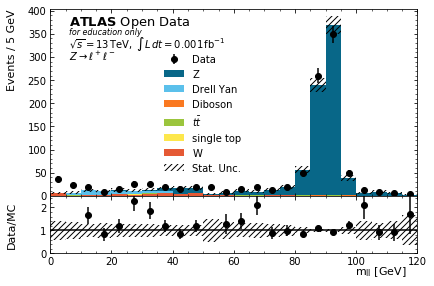

In [85]:
signal_yields,background_yields = plot_data(data)